<a href="https://colab.research.google.com/github/mmaghajani/RL-up-running/blob/main/DQN_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pong Game using Deep-Q Network

In [1]:
import gym
import random
import matplotlib.pyplot as plt
import numpy as np

### Prepare Env

In [2]:
!wget 'http://www.atarimania.com/roms/Roms.rar'

--2021-09-16 10:24:41--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   816KB/s    in 14s     

2021-09-16 10:24:55 (787 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



In [3]:
!mkdir roms
!unrar x -r Roms.rar roms


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  roms/HC ROMS.zip                                              36%  OK 
Extracting  roms/ROMS.zip                                                 74% 99%  OK 
All OK


In [4]:
!python -m atari_py.import_roms roms

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [5]:
env = gym.make('PongDeterministic-v4')

### Preprocess Frames

In [6]:
import cv2

In [7]:
def resize_frame(frame):
  frame = frame[30:-12, 5:-4]
  frame = 0.2989*frame[:,:,0] + 0.5870*frame[:,:,1] + 0.1140*frame[:,:,2]
  frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
  frame = np.array(frame,dtype = np.uint8)
  return frame

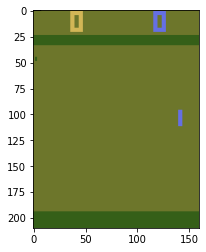

In [8]:
first_frame = env.reset()
plt.imshow(first_frame)

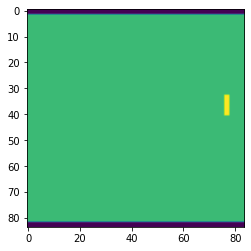

In [9]:
plt.imshow(resize_frame(first_frame))

### MemoryBuffer

In [10]:
from collections import deque

class MemoryBuffer():
  def __init__(self, max_len):
    self.max_len = max_len
    self.frames = deque(maxlen=max_len)
    self.actions = deque(maxlen=max_len)
    self.rewards = deque(maxlen=max_len)
    self.done_flags = deque(maxlen=max_len)

  def add_experience(self, frame, reward, action, is_done):
    self.frames.append(frame)
    self.actions.append(action)
    self.rewards.append(reward)
    self.done_flags.append(is_done)

  def _index_valid(self,index):
    if self.done_flags[index-3] or self.done_flags[index-2] or self.done_flags[index-1] or self.done_flags[index]:
        return False
    else:
        return True
    
  def sample_experinece(self, batch_size):
    states = []
    next_states = []
    actions_taken = []
    next_rewards = []
    next_done_flags = []

    while len(states) < batch_size:
      index = np.random.randint(4,len(self.frames) - 1)
      if self._index_valid(index):
          state = [self.frames[index-3], self.frames[index-2], self.frames[index-1], self.frames[index]]
          state = np.moveaxis(state,0,2)/255
          next_state = [self.frames[index-2], self.frames[index-1], self.frames[index], self.frames[index+1]]
          next_state = np.moveaxis(next_state,0,2)/255

          states.append(state)
          next_states.append(next_state)
          actions_taken.append(self.actions[index])
          next_rewards.append(self.rewards[index+1])
          next_done_flags.append(self.done_flags[index+1])
                        
    return states, next_states, actions_taken, next_rewards, next_done_flags

### The Agent

In [11]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

In [12]:
class Agent():
  def __init__(
    self, 
    possible_actions, 
    starting_mem_length, 
    max_mem_length, 
    learning_rate,
    q_eval_model_file,
    q_target_model_file, 
    debug=False,
    starting_epsilon=1,
    end_epsilon=0.05,
    gamma=0.95,
    epsilon_decay=0.0000009,
  ):
    self.memory_buffer = MemoryBuffer(max_mem_length)
    self.possible_actions = possible_actions
    self.epsilon = starting_epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = end_epsilon
    self.gamma = gamma
    self.learning_rate = learning_rate
    self.q_eval = self._build_model()
    self.q_target = clone_model(self.q_eval)
    self.total_steps = 0
    self.starting_mem_length = starting_mem_length
    self.q_eval_model_file = q_eval_model_file
    self.q_target_model_file = q_target_model_file
  
  def _build_model(self):
    model = Sequential([
      Input((84,84,4)),
      Conv2D(
          filters=32,
          kernel_size=(8,8),
          strides=4,
          data_format="channels_last", 
          activation='relu',
          kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2)
      ),
      Conv2D(
          filters=64,
          kernel_size=(4,4),
          strides=2,
          data_format="channels_last", 
          activation='relu',
          kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2)
      ),
      Conv2D(
          filters=64,
          kernel_size=(3,3),
          strides=1,
          data_format="channels_last", 
          activation='relu',
          kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2)
      ),
      Flatten(),
      Dense(
          units=512,
          activation='relu', 
          kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2)
      ),
      Dense(
          units=len(self.possible_actions), 
          activation='linear'
      ),
    ])

    optimizer = Adam(self.learning_rate)
    model.compile(optimizer, loss=tf.keras.losses.Huber())
    
    model.summary()
    print('\nAgent Initialized\n')
    
    return model

  def choose_action(self, frame):
    if np.random.rand() < self.epsilon:
      return random.sample(self.possible_actions, 1)[0]
    else:
      state = [self.memory_buffer.frames[-3], self.memory_buffer.frames[-2], self.memory_buffer.frames[-1], frame]
      state = np.moveaxis(state,0,2)/255 #We have to do this to get it into keras's goofy format of [batch_size,rows,columns,channels]
      state = np.expand_dims(state,0) #^^^
      action_index = np.argmax(self.q_eval.predict(state))
      return self.possible_actions[action_index]

  def learn(self, debug, batch_size):

    states, next_states, actions_taken, rewards, done_flags = self.memory_buffer.sample_experinece(batch_size)

    labels = self.q_eval.predict(np.array(states))
    next_state_values = self.q_target.predict(np.array(next_states))

    for i in range(batch_size):
      action = self.possible_actions.index(acitions_taken[i])
      labels[i][action] = rewards[i] + (not done_flags[i]) * self.gamma * max(next_state_values[i])

    self.q_eval.fit(np.array(states), labels, batch_size=batch_size, epochs=1, verbose=0)

    if self.epsilon > self.end_epsilon:
      self.epsilon -= self.epsilon_decay

    self.learns += 1

    if self.learns % 10000 == 0:
      self.q_target.set_weights(self.q_eval.get_weights())
      print("Target Model updated")

  def save_model(self):
        self.q_eval.save(self.q_eval_model_file)
        self.q_target.save(self.q_target_model_file)

  def load_model(self):
      self.q_eval=load_model(self.q_eval_model_file)
      self.q_target=laod_model(self.q_target_model_file)

### Environment Wrapper

In [13]:
class ThePlay():
  def __init__(self, env_name, agent):
    self.env = gym.make(env_name)
    self.agent = agent
    self.env.reset()
    

  def _make_dummy_actions(self, number_of_actions=4):
    starting_frame = resize_frame(self.env.step(0)[0])
    dummy_action = 0
    dummy_reward = 0
    dummy_done = False
    for i in range(number_of_actions):
        self.agent.memory_buffer.add_experience(starting_frame, dummy_reward, dummy_action, dummy_done)

    return starting_frame

  def take_step(self, frame, debug):
    self.agent.total_steps += 1
    if self.agent.total_steps % 10000 == 0:
      self.agent.save()
      print('agent saved!')

    action = self.agent.choose_action(frame)
    next_frame, reward, is_done, info = self.env.step(action)
    next_frame = resize_frame(next_frame)
    self.agent.memory_buffer.add_experience(next_frame, reward, action, is_done)

    if debug:
        env.render()

    if len(self.agent.memory_buffer.frames) > self.agent.starting_mem_length:
        self.agent.learn(debug)

    if is_done:
      return reward, next_frame, True
    else:
      return reward, next_frame, False
  
  def play_episode(self, debug):
    starting_frame = self._make_dummy_actions(number_of_actions=4)
    done = False
    score = 0
    next_frame = starting_frame
    while True:
      reward, next_frame, done = self.take_step(next_frame, debug)
      score += reward
      if done:
        break
    
    return score

  

### Training

In [ ]:
import time


agent = Agent(
    possible_actions=[0,2,3], 
    starting_mem_length=50000, 
    max_mem_length=750000, 
    learning_rate=0.0002, 
    debug=False,
    starting_epsilon=1,
    end_epsilon=0.05,
    gamma=0.95,
    epsilon_decay=0.0000009,
    q_eval_model_file='agent.h5',
    q_target_model_file='agent.h5',
)
env = ThePlay(env_name='PongDeterministic-v4', agent=agent)

last_100_avg = [-21]
scores = deque(maxlen = 100)
max_score = -21

for i in range(100000):
  timesteps = agent.total_steps
  timee = time.time()
  score = env.play_episode(debug=False) # set debug to true for rendering
  scores.append(score)
  if score > max_score:
      max_score = score

  print('\nEpisode: ' + str(i))
  print('Steps: ' + str(agent.total_steps - timesteps))
  print('Duration: ' + str(time.time() - timee))
  print('Score: ' + str(score))
  print('Max Score: ' + str(max_score))
  print('Epsilon: ' + str(agent.epsilon))

  if i%100==0 and i!=0:
      last_100_avg.append(sum(scores)/len(scores))
      plt.plot(np.arange(0,i+1,100),last_100_avg)
      plt.show()